<a href="https://colab.research.google.com/github/tanyatoluay/DataScience/blob/master/HW_II%26III_SU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Assignment 2 & 3**

**Task 1:** The paper by Spanhol et al. describes a dataset for breast cancer histopathological image classification. The dataset contains 7909 images of breast tumor tissue with different magnifying factors. The authors used the dataset to evaluate a variety of machine learning methods for breast cancer classification, including support vector machines, random forests, and convolutional neural networks.

In [ ]:
# Data import from Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Data Overview:** Breast Tissue Biopsy Samples

This dataset comprises breast tissue biopsy samples used for research purposes. The samples are derived from slides stained with hematoxylin and eosin (HE), primarily intended for histological study. Pathologists at the P&D Lab labeled these samples, which include breast tumor specimens assessed using Immunohistochemistry (IHC).

These samples originate from both Core Needle Biopsy (CNB) and Surgical Open Biopsy (SOB) procedures, with a typical section thickness of approximately 3µm.

Image acquisition was performed using an Olympus BX-50 microscope system coupled with a Samsung digital color camera (SCC-131AN). Images were captured at magnifications of 40×, 100×, 200×, and 400×, yielding raw images in 3-channel RGB with an 8-bit depth in each channel. Notably, the images have not undergone normalization or color standardization.

The filenames of the images adhere to a specific format for easy identification and categorization. Each filename includes details such as the biopsy procedure, tumor classification, type, year, slide ID, magnification, and sequence number, aiding in future referencing and analysis.



In [ ]:
# Import required libraries
import numpy as np
import pandas as pd
import os
import scipy
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import MobileNetV2
from keras.preprocessing.image import ImageDataGenerator
import glob
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory


There are 588 benign images 
There are 1232 malign images 
There are 1273 training images 
There are 182 validation images 
There are 365 test images 
Found 1273 validated image filenames belonging to 2 classes.
Found 182 validated image filenames belonging to 2 classes.
Found 365 validated image filenames belonging to 2 classes.
Batch shape:  (32, 224, 224, 3)
Label shape:  (32,)
Label:  0.0


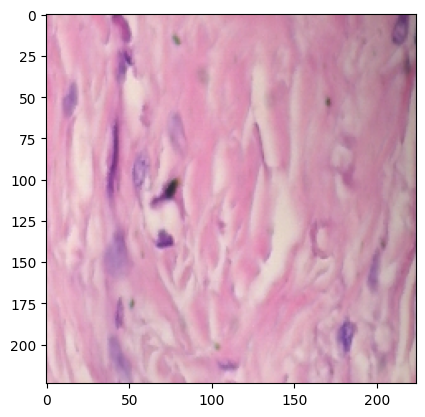

In [ ]:
# Paths of benign and malignant images, importing 400x
benign_images =[]
for img in glob.glob('/content/drive/MyDrive/BreaKHis_v1/histology_slides/breast/benign/SOB/*/*/400X/*.png'):
    benign_images.append(img)
malign_images =[]
for img in glob.glob('/content/drive/MyDrive/BreaKHis_v1/histology_slides/breast/malignant/SOB/*/*/400X/*.png'):
    malign_images.append(img)

# Printing the count of collected benign and malignant images
print('There are {} benign images '.format(len(benign_images)))
print('There are {} malign images '.format(len(malign_images)))

# Splitting the images into training, validation, and test sets
train_ben,val_ben,test_ben = np.split(benign_images,[int(len(benign_images)*0.7),int(len(benign_images)*0.8)])
train_mal,val_mal,test_mal = np.split(malign_images,[int(len(malign_images)*0.7),int(len(malign_images)*0.8)])

# Shuffling the lists of images
np.random.shuffle(benign_images)
np.random.shuffle(malign_images)

# Creating DataFrames for training, validation, and test sets
train_ben_df = pd.DataFrame({'image':train_ben,'label':'1'})
val_ben_df = pd.DataFrame({'image':val_ben,'label':'1'})
test_ben_df = pd.DataFrame({'image':test_ben,'label':'1'})

train_mal_df = pd.DataFrame({'image':train_mal,'label':'0'})
val_mal_df = pd.DataFrame({'image':val_mal,'label':'0'})
test_mal_df = pd.DataFrame({'image':test_mal,'label':'0'})

train_df = pd.concat([train_ben_df,train_mal_df])
val_df = pd.concat([val_ben_df,val_mal_df])
test_df = pd.concat([test_ben_df,test_mal_df])

# Printing the count of images in each dataset
print('There are {} training images '.format(len(train_df)))
print('There are {} validation images '.format(len(val_df)))
print('There are {} test images '.format(len(test_df)))

# Constants for image batch processing
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

# Creating ImageDataGenerator objects and rescaling the images
trainGenerator = ImageDataGenerator(rescale=1./255.)
valGenerator = ImageDataGenerator(rescale=1./255.)
testGenerator = ImageDataGenerator(rescale=1./255.)

# Converting DataFrames into datasets for model training and validation
trainDataset = trainGenerator.flow_from_dataframe(
  dataframe=train_df,
  class_mode="binary",
  x_col="image",
  y_col="label",
  batch_size=BATCH_SIZE,
  seed=42,
  shuffle=True,
  target_size=(IMG_HEIGHT,IMG_WIDTH) #set the height and width of the images
)

valDataset = valGenerator.flow_from_dataframe(
  dataframe=val_df,
  class_mode='binary',
  x_col="image",
  y_col="label",
  batch_size=BATCH_SIZE,
  seed=42,
  shuffle=True,
  target_size=(IMG_HEIGHT,IMG_WIDTH)
)

testDataset = testGenerator.flow_from_dataframe(
  dataframe=test_df,
  class_mode='binary',
  x_col="image",
  y_col="label",
  batch_size=BATCH_SIZE,
  seed=42,
  shuffle=True,
  target_size=(IMG_HEIGHT,IMG_WIDTH)
)

# Checking the shape of a batch of images and labels, and displaying an image with its label
images, labels = next(iter(testDataset))

print('Batch shape: ', images.shape)
print('Label shape: ', labels.shape)

plt.imshow(images[3])
print('Label: ', labels[3])



**Task 2:**

I- Below code defines a **convolutional neural network (CNN)** model with several convolutional and pooling layers followed by a global average pooling layer and a dense output layer with a sigmoid activation function. It then compiles the model with binary cross-entropy loss and Adam optimizer, and proceeds to train the model using the provided training and validation datasets for a specified number of epochs.

In [ ]:
# Define the model architecture
model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(256, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(512, (3, 3), activation='relu'),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

# Define the number of epochs
epochs=15

# Compile the model
#model.compile(loss='binary_crossentropy',
#              optimizer='adam',
#              metrics=['accuracy', tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tf.keras.metrics.F1Score()])


model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),
                       tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.AUC(),
                       tf.keras.metrics.TruePositives(), tf.keras.metrics.TrueNegatives(),
                       tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives()])


# Train the model
history = model.fit(trainDataset, epochs=epochs, validation_data=(valDataset))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 256)      0

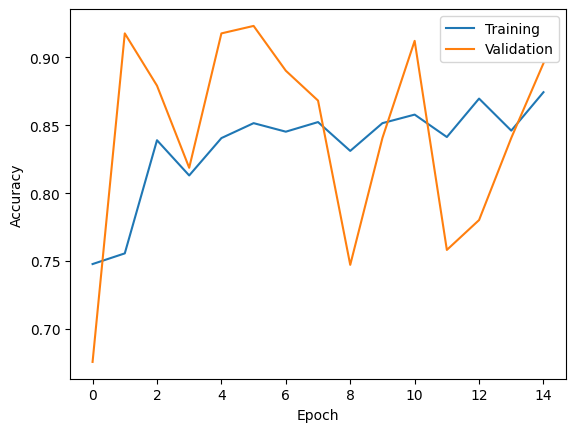

12/12 [==============================] - 95s 8s/step - loss: 0.4736 - accuracy: 0.8000 - precision: 0.7064 - recall: 0.6525 - binary_accuracy: 0.8000 - auc: 0.8793 - true_positives: 77.0000 - true_negatives: 215.0000 - false_positives: 32.0000 - false_negatives: 41.0000
results: [0.47362035512924194, 0.800000011920929, 0.7064220309257507, 0.6525423526763916, 0.800000011920929, 0.8792630434036255, 77.0, 215.0, 32.0, 41.0]


In [ ]:
# Plotting training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

# Labeling the axes
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])

plt.show()

# Evaluating the model on the test dataset
results = model.evaluate(testDataset)
print('results:', results)
#print('Accuracy:', acc)

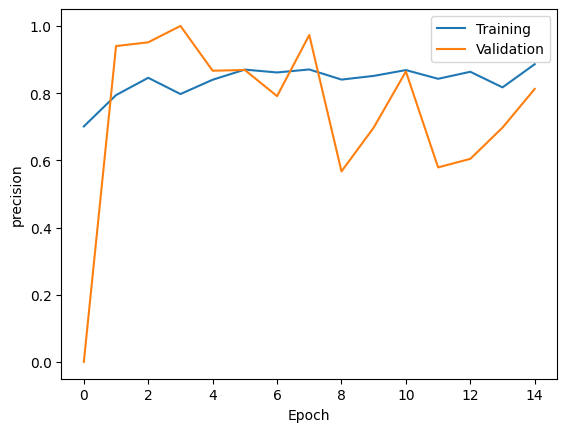

In [ ]:
# Plotting the precision scores for the training set
plt.plot(history.history['precision'])

# Plotting the precision scores for the validation set
plt.plot(history.history['val_precision'])

# Labeling the axes
plt.xlabel('Epoch')
plt.ylabel('precision')

# Adding a legend to differentiate between training and validation precision scores
plt.legend(['Training', 'Validation'])

# Displaying the plot
plt.show()

In [ ]:
# Make predictions on the test dataset
predictions = model.predict(testDataset)
predicted_classes = np.where(predictions > 0.5, 1, 0)

# Calculate precision manually
from sklearn.metrics import precision_score

true_labels = test_df['label'].astype(int)
precision = precision_score(true_labels, predicted_classes)

print(f"Precision Score: {precision}")

# Create a confusion matrix using sklearn
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(true_labels, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

12/12 [==============================] - 68s 5s/step
Precision Score: 0.3119266055045872
Confusion Matrix:
[[172  75]
 [ 84  34]]


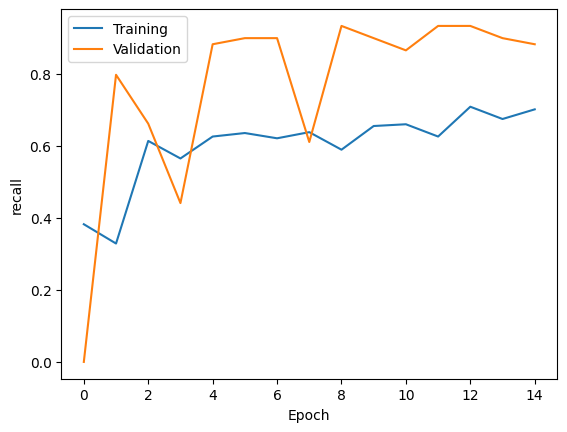

In [ ]:
# Plotting the recall scores
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])

# Labeling the axes
plt.xlabel('Epoch')
plt.ylabel('recall')

# Adding a legend to differentiate between training and validation recall scores
plt.legend(['Training', 'Validation'])

# Displaying the plot
plt.show()

II- The below code defines a **neural network model using Keras Sequential API** with specific layer configurations:

1.   Flatten: Reshapes the input data into a 1D array before passing it to the dense layers.
2.   Dense: A densely connected layer with 128 units and ReLU activation function, serving as the hidden layer.
3.   Another Dense layer with 1 unit and sigmoid activation, acting as the output layer for binary classification tasks (predicting a binary label).


In [ ]:
# Creating a Sequential model architecture with dense layers

# Define the model architecture
model_2 = keras.Sequential([
    # Flatten layer to convert input data into a 1D array
    keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    # Dense hidden layer with 128 units and ReLU activation function
    keras.layers.Dense(units=128, activation= 'relu'),
    # Output layer with 1 unit and sigmoid activation for binary classification
    keras.layers.Dense(units=1, activation='sigmoid')
])
# Display a summary of the model architecture
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense_1 (Dense)             (None, 128)               19267712  
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 19,267,841
Trainable params: 19,267,841
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Defining the number of epochs for model training
epochs = 15

# Compiling the model_2 with optimizer, loss function, and evaluation metrics
model_2.compile(optimizer = 'adam',
                loss='binary_crossentropy',
                metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),
                       tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.AUC(),
                       tf.keras.metrics.TruePositives(), tf.keras.metrics.TrueNegatives(),
                       tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives()])

# Training the model_2 using the training dataset and validating on the validation dataset
history_2 = model_2.fit(trainDataset, epochs =epochs, validation_data=(valDataset))



Epoch 1/15
40/40 [==============================] - 51s 1s/step - loss: 17.7985 - accuracy: 0.6017 - precision_3: 0.3756 - recall_3: 0.3528 - binary_accuracy: 0.6017 - auc_1: 0.5535 - true_positives_1: 145.0000 - true_negatives_1: 621.0000 - false_positives_1: 241.0000 - false_negatives_1: 266.0000 - val_loss: 1.3150 - val_accuracy: 0.7418 - val_precision_3: 1.0000 - val_recall_3: 0.2034 - val_binary_accuracy: 0.7418 - val_auc_1: 0.8589 - val_true_positives_1: 12.0000 - val_true_negatives_1: 123.0000 - val_false_positives_1: 0.0000e+00 - val_false_negatives_1: 47.0000
Epoch 2/15
40/40 [==============================] - 44s 1s/step - loss: 3.4219 - accuracy: 0.7046 - precision_3: 0.5436 - recall_3: 0.5304 - binary_accuracy: 0.7046 - auc_1: 0.6964 - true_positives_1: 218.0000 - true_negatives_1: 679.0000 - false_positives_1: 183.0000 - false_negatives_1: 193.0000 - val_loss: 0.2927 - val_accuracy: 0.9396 - val_precision_3: 0.9138 - val_recall_3: 0.8983 - val_binary_accuracy: 0.9396 - val

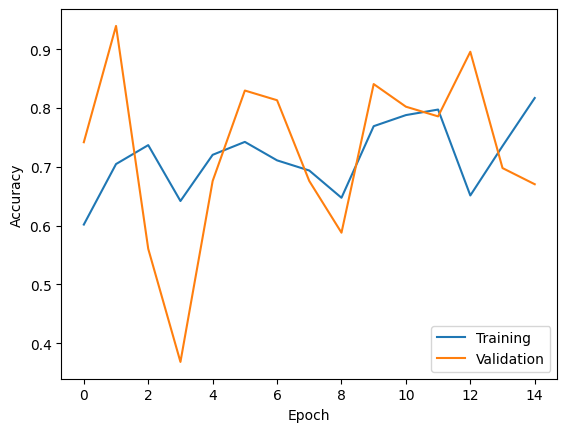

12/12 [==============================] - 8s 685ms/step - loss: 1.8268 - accuracy: 0.4740 - precision_3: 0.3715 - recall_3: 0.9068 - binary_accuracy: 0.4740 - auc_1: 0.6301 - true_positives_1: 107.0000 - true_negatives_1: 66.0000 - false_positives_1: 181.0000 - false_negatives_1: 11.0000
results [1.8267992734909058, 0.4739725887775421, 0.3715277910232544, 0.9067796468734741, 0.4739725887775421, 0.6300521492958069, 107.0, 66.0, 181.0, 11.0]


In [ ]:
# Plotting the training accuracy
plt.plot(history_2.history['accuracy'])

# Plotting the validation accuracy
plt.plot(history_2.history['val_accuracy'])

# Labeling the axes
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Adding a legend to differentiate between training and validation accuracy
plt.legend(['Training', 'Validation'])
plt.show()

# Evaluating the model on the test dataset
#loss, acc = model_2.evaluate(testDataset)
results = model_2.evaluate(testDataset)
print('results', results)
#print('Loss:', loss)
#print('Accuracy:', acc)

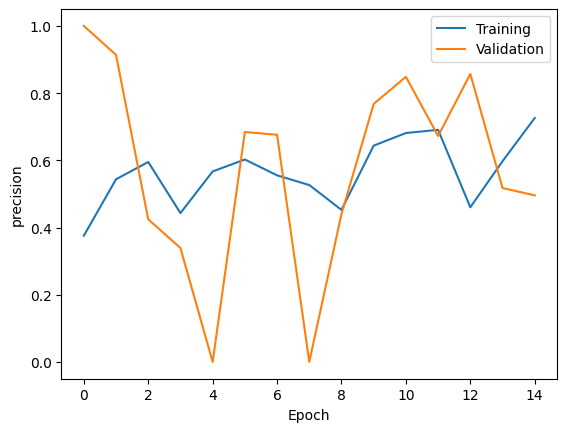

In [ ]:
# Plotting the precision scores
plt.plot(history_2.history['precision_3'])
# Plotting the precision scores
plt.plot(history_2.history['val_precision_3'])

# Labeling the axes
plt.xlabel('Epoch')
plt.ylabel('precision')

# Adding a legend to differentiate between training and validation precision scores
plt.legend(['Training', 'Validation'])

plt.show()

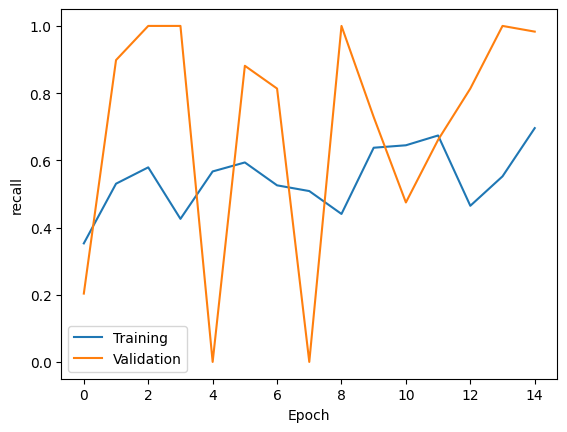

In [ ]:
# Plotting the recall scores for the training set
plt.plot(history_2.history['recall_3'])

# Plotting the recall scores for the validation set
plt.plot(history_2.history['val_recall_3'])

# Labeling the axes
plt.xlabel('Epoch')
plt.ylabel('recall')

# Adding a legend to differentiate between training and validation recall scores
plt.legend(['Training', 'Validation'])

plt.show()

III- Below code initializes the **MobileNetV2 model with pre-trained weights from ImageNet** and configures it to exclude the top classification layers.
Constructs a new Sequential model (model_3) consisting of the MobileNetV2 base, a GlobalAveragePooling2D layer to reduce spatial dimensions, and a Dense output layer with a sigmoid activation function for binary classification.
Freezes the weights of the MobileNetV2 layers to prevent further training and retain the pre-trained knowledge while adding new classification layers on top.
Lastly, it displays a summary of the model_3 architecture detailing the layers, shapes, and parameters.

In [ ]:
# Loading the MobileNetV2 model with pre-trained weights and excluding the top classification layers

# Create the base MobileNetV2 model excluding the top classification layers
base_model = MobileNetV2(include_top=False, weights='imagenet',input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Constructing a Sequential model on top of the MobileNetV2 base

# Compose the Sequential model with MobileNetV2 as the base, followed by GlobalAveragePooling2D and a Dense output layer
model_3 = keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(units=1,activation ='sigmoid')
])

# Freezing the weights of the MobileNetV2 layers to retain pre-trained knowledge

# Iterate through each layer in the base MobileNetV2 model and set them as non-trainable
for layer in base_model.layers:
  layer.trainable =False

# Display a summary of the model architecture
model_3.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
# Defining the number of epochs for training
epochs = 15

# Compiling the model_3 with optimizer, loss function, and evaluation metrics

# Compile the model using the Adam optimizer, binary cross-entropy loss for binary classification,
# and multiple evaluation metrics including accuracy, precision, recall, and F1 score
model_3.compile(optimizer = 'adam',
                loss='binary_crossentropy',
                metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),
                       tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.AUC(),
                       tf.keras.metrics.TruePositives(), tf.keras.metrics.TrueNegatives(),
                       tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives()])

# Train model_3 using the specified number of epochs and providing the validation dataset for evaluation
history_3 = model_3.fit(trainDataset, epochs =epochs, validation_data=(valDataset))

Epoch 1/15
40/40 [==============================] - 95s 2s/step - loss: 0.2520 - accuracy: 0.9057 - precision_6: 0.8839 - recall_6: 0.8151 - binary_accuracy: 0.9057 - auc_3: 0.9656 - true_positives_3: 335.0000 - true_negatives_3: 818.0000 - false_positives_3: 44.0000 - false_negatives_3: 76.0000 - val_loss: 0.4654 - val_accuracy: 0.7253 - val_precision_6: 0.5763 - val_recall_6: 0.5763 - val_binary_accuracy: 0.7253 - val_auc_3: 0.8370 - val_true_positives_3: 34.0000 - val_true_negatives_3: 98.0000 - val_false_positives_3: 25.0000 - val_false_negatives_3: 25.0000
Epoch 2/15
40/40 [==============================] - 86s 2s/step - loss: 0.2411 - accuracy: 0.9144 - precision_6: 0.8775 - recall_6: 0.8540 - binary_accuracy: 0.9144 - auc_3: 0.9698 - true_positives_3: 351.0000 - true_negatives_3: 813.0000 - false_positives_3: 49.0000 - false_negatives_3: 60.0000 - val_loss: 0.4405 - val_accuracy: 0.7692 - val_precision_6: 0.6977 - val_recall_6: 0.5085 - val_binary_accuracy: 0.7692 - val_auc_3: 0

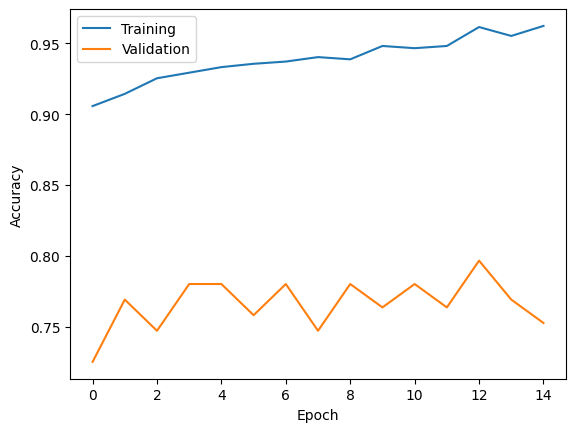

12/12 [==============================] - 36s 3s/step - loss: 1.0123 - accuracy: 0.6137 - precision_6: 0.3580 - recall_6: 0.2458 - binary_accuracy: 0.6137 - auc_3: 0.5661 - true_positives_3: 29.0000 - true_negatives_3: 195.0000 - false_positives_3: 52.0000 - false_negatives_3: 89.0000
results [1.0123032331466675, 0.6136986017227173, 0.3580246865749359, 0.24576270580291748, 0.6136986017227173, 0.5660811066627502, 29.0, 195.0, 52.0, 89.0]


In [ ]:
# Plotting the training accuracy
plt.plot(history_3.history['accuracy'])
# Plotting the validation accuracy
plt.plot(history_3.history['val_accuracy'])

# Labeling the axes
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Adding a legend to differentiate between training and validation accuracy
plt.legend(['Training', 'Validation'])

plt.show()

# Evaluating model_3 on the test dataset and printing the results
results = model_3.evaluate(testDataset)
print('results', results)

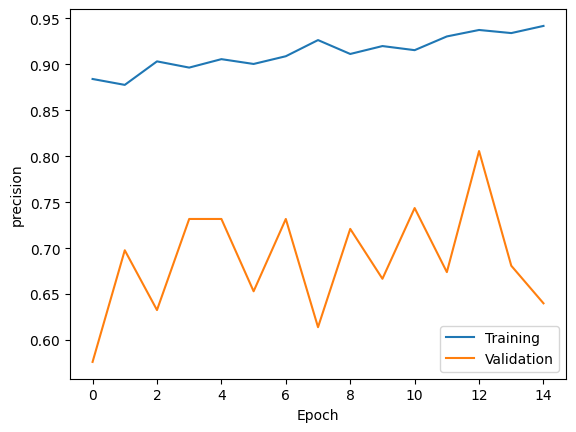

In [ ]:
# Plotting the precision scores for the training set
plt.plot(history_3.history['precision_6'])

# Plotting the precision scores for the validation set
plt.plot(history_3.history['val_precision_6'])

# Labeling the axes
plt.xlabel('Epoch')
plt.ylabel('precision')

# Adding a legend to differentiate between training and validation precision scores
plt.legend(['Training', 'Validation'])

plt.show()

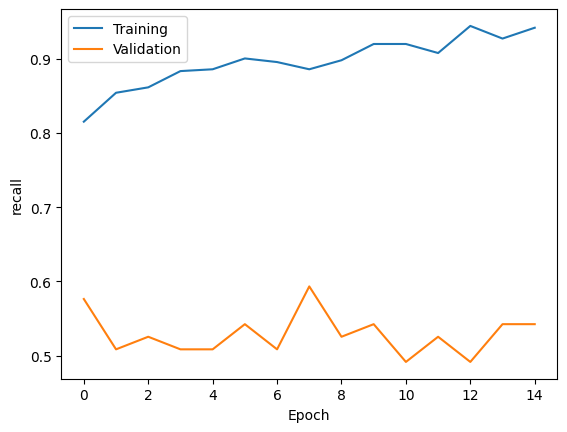

In [ ]:
# Plotting the recall scores for the training set
plt.plot(history_3.history['recall_6'])

# Plotting the recall scores for the validation set
plt.plot(history_3.history['val_recall_6'])

# Labeling the axes
plt.xlabel('Epoch')
plt.ylabel('recall')

# Adding a legend to differentiate between training and validation recall scores
plt.legend(['Training', 'Validation'])

plt.show()

# Asignment 3

Rerun the project from the second asignment with one other
magnification level -> We are selecting the x40 magnification level and importing the data.

1. **Random Rotation Augmentation:**
-Robustness to Variations: Tumor images may be captured from different angles or orientations. By applying random rotations within a certain range, the model learns to recognize tumors irrespective of their orientations in images, making it more robust to variations in how the tumors are positioned or presented.

-Generalization: Rotating images mimics real-world scenarios where tumors might not always be perfectly aligned. This augmentation helps prevent overfitting by exposing the model to a wider variety of tumor orientations during training.

2. **Horizontal and Vertical Flip Augmentation:**

-Increased Data Diversity: Flipping images horizontally or vertically provides additional variations of the same tumor, enhancing the diversity of the training dataset. This variety can help the model better generalize to different perspectives or asymmetrical features present in tumors.

-Augmenting Limited Data: In medical imaging, acquiring large datasets can be challenging due to privacy concerns or data acquisition limitations. Augmenting data through flips allows you to generate more training samples from the existing limited dataset, thereby improving the model's performance.

In [ ]:
# Paths of benign and malignant images, importing 40x
benign_images_2 =[]
for img in glob.glob('/content/drive/MyDrive/BreaKHis_v1/histology_slides/breast/benign/SOB/*/*/40X/*.png'):
    benign_images_2.append(img)
malign_images_2 =[]
for img in glob.glob('/content/drive/MyDrive/BreaKHis_v1/histology_slides/breast/malignant/SOB/*/*/40X/*.png'):
    malign_images_2.append(img)

# Printing the count of benign and malignant images
print('There are {} benign images '.format(len(benign_images_2)))
print('There are {} malign images '.format(len(malign_images_2)))

# Splitting the data into train, validation, and test sets
train_ben,val_ben,test_ben = np.split(benign_images_2,[int(len(benign_images_2)*0.7),int(len(benign_images_2)*0.8)])
train_mal,val_mal,test_mal = np.split(malign_images_2,[int(len(malign_images_2)*0.7),int(len(malign_images_2)*0.8)])

# Randomly shuffling the data
np.random.shuffle(benign_images_2)
np.random.shuffle(malign_images_2)

# Creating DataFrames for train, validation, and test sets
train_ben_df = pd.DataFrame({'image':train_ben,'label':'1'})
val_ben_df = pd.DataFrame({'image':val_ben,'label':'1'})
test_ben_df = pd.DataFrame({'image':test_ben,'label':'1'})

train_mal_df = pd.DataFrame({'image':train_mal,'label':'0'})
val_mal_df = pd.DataFrame({'image':val_mal,'label':'0'})
test_mal_df = pd.DataFrame({'image':test_mal,'label':'0'})

train_df = pd.concat([train_ben_df,train_mal_df])
val_df = pd.concat([val_ben_df,val_mal_df])
test_df = pd.concat([test_ben_df,test_mal_df])

# Printing the count of images in training, validation, and test sets
print('There are {} training images '.format(len(train_df)))
print('There are {} validation images '.format(len(val_df)))
print('There are {} test images '.format(len(test_df)))

# Constants for image processing
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

# Creating ImageDataGenerator objects with augmentation
trainGenerator = ImageDataGenerator(
    rescale=1./255.,
    horizontal_flip=True,  # Augmentation: Horizontal Flip
    vertical_flip=True,    # Augmentation: Vertical Flip
    rotation_range=30       # Augmentation: Random Rotation (rotate images randomly up to 30 degrees)
)

valGenerator = ImageDataGenerator(rescale=1./255.)
testGenerator = ImageDataGenerator(rescale=1./255.)

# Converting data into datasets
trainDataset = trainGenerator.flow_from_dataframe(
    dataframe=train_df,
    class_mode="binary",
    x_col="image",
    y_col="label",
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    target_size=(IMG_HEIGHT,IMG_WIDTH) #set the height and width of the images
)

valDataset = valGenerator.flow_from_dataframe(
    dataframe=val_df,
    class_mode='binary',
    x_col="image",
    y_col="label",
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    target_size=(IMG_HEIGHT,IMG_WIDTH)
)

testDataset = testGenerator.flow_from_dataframe(
    dataframe=test_df,
    class_mode='binary',
    x_col="image",
    y_col="label",
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    target_size=(IMG_HEIGHT,IMG_WIDTH)
)


# Creating ImageDataGenerator objects and rescaling the images
trainGenerator = ImageDataGenerator(rescale=1./255.)
valGenerator = ImageDataGenerator(rescale=1./255.)
testGenerator = ImageDataGenerator(rescale=1./255.)

# Extracting a batch of images and labels from the test dataset
images, labels = next(iter(testDataset))

# Displaying shapes and a label from the test dataset
print('Batch shape: ', images.shape)
print('Label shape: ', labels.shape)
print('Label: ', labels[3])

There are 625 benign images 
There are 1370 malign images 
There are 1395 training images 
There are 201 validation images 
There are 399 test images 
Found 1395 validated image filenames belonging to 2 classes.
Found 201 validated image filenames belonging to 2 classes.
Found 399 validated image filenames belonging to 2 classes.
Batch shape:  (32, 224, 224, 3)
Label shape:  (32,)
Label:  0.0


In [ ]:
model_40 = keras.Sequential([
    keras.layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(256, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(512, (3, 3), activation='relu'),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(1, activation='sigmoid')

])

model_40.summary()


epochs=15

model_40.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),
                       tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.AUC(),
                       tf.keras.metrics.TruePositives(), tf.keras.metrics.TrueNegatives(),
                       tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives()])
history_40 = model_40.fit(trainDataset, epochs=epochs, validation_data=(valDataset))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 111, 111, 64)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 109, 109, 128)     73856     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 54, 54, 128)      0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 52, 52, 256)       295168    
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 26, 26, 256)     

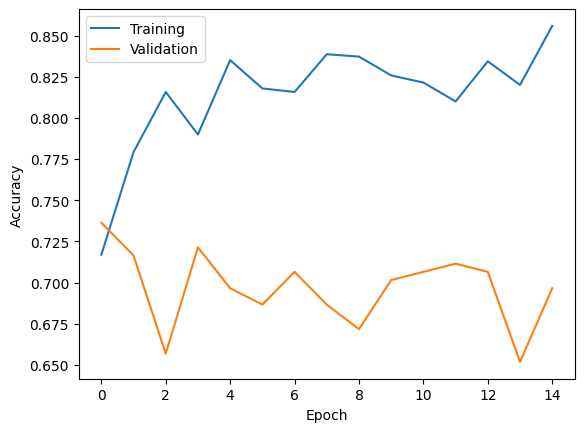

13/13 [==============================] - 57s 4s/step - loss: 0.5713 - accuracy: 0.8045 - precision_8: 0.6691 - recall_8: 0.7440 - binary_accuracy: 0.8045 - auc_4: 0.8616 - true_positives_4: 93.0000 - true_negatives_4: 228.0000 - false_positives_4: 46.0000 - false_negatives_4: 32.0000
results: [0.571312427520752, 0.8045112490653992, 0.6690647602081299, 0.7440000176429749, 0.8045112490653992, 0.8616350293159485, 93.0, 228.0, 46.0, 32.0]


In [ ]:
plt.plot(history_40.history['accuracy'])
plt.plot(history_40.history['val_accuracy'])


plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.show()

results = model_40.evaluate(testDataset)

print('results:', results)
#print('Accuracy:', acc)

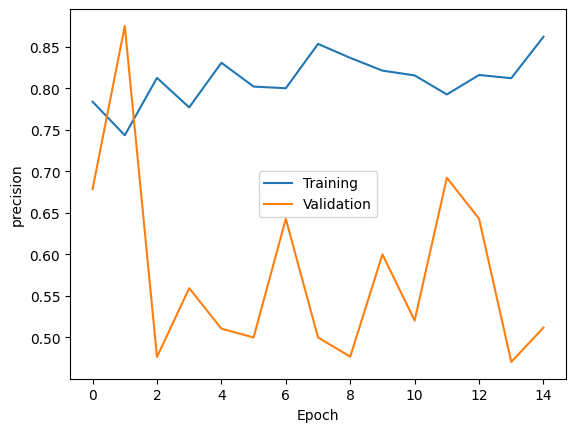

In [ ]:
plt.plot(history_40.history['precision_8'])
plt.plot(history_40.history['val_precision_8'])

plt.xlabel('Epoch')
plt.ylabel('precision')
plt.legend(['Training', 'Validation'])
plt.show()

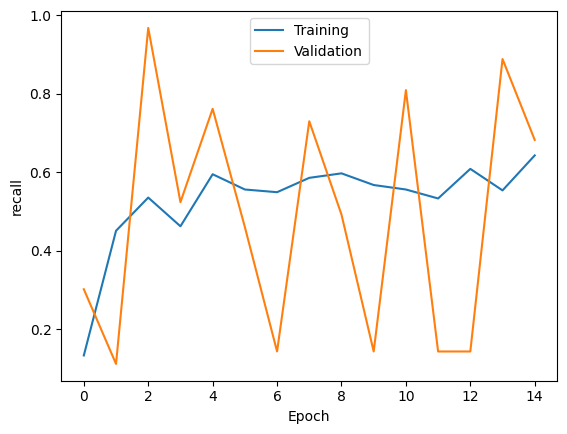

In [ ]:
plt.plot(history_40.history['recall_8'])
plt.plot(history_40.history['val_recall_8'])

plt.xlabel('Epoch')
plt.ylabel('recall')
plt.legend(['Training', 'Validation'])
plt.show()

In [ ]:
model_2_40 = keras.Sequential([
    keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    keras.layers.Dense(units=128, activation= 'relu'),
    keras.layers.Dense(units=1, activation='sigmoid')
])
model_2_40.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 150528)            0         
                                                                 
 dense_6 (Dense)             (None, 128)               19267712  
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 19,267,841
Trainable params: 19,267,841
Non-trainable params: 0
_________________________________________________________________


In [ ]:
epochs = 15
model_2_40.compile(optimizer = 'adam',
                loss='binary_crossentropy',
                metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),
                       tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.AUC(),
                       tf.keras.metrics.TruePositives(), tf.keras.metrics.TrueNegatives(),
                       tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives()])

history_2_40 = model_2_40.fit(trainDataset, epochs =epochs, validation_data=(valDataset))



Epoch 1/15
44/44 [==============================] - 85s 2s/step - loss: 17.6726 - accuracy: 0.5892 - precision_10: 0.3426 - recall_10: 0.3387 - binary_accuracy: 0.5892 - auc_5: 0.5192 - true_positives_5: 148.0000 - true_negatives_5: 674.0000 - false_positives_5: 284.0000 - false_negatives_5: 289.0000 - val_loss: 2.0655 - val_accuracy: 0.6866 - val_precision_10: 0.0000e+00 - val_recall_10: 0.0000e+00 - val_binary_accuracy: 0.6866 - val_auc_5: 0.4971 - val_true_positives_5: 0.0000e+00 - val_true_negatives_5: 138.0000 - val_false_positives_5: 0.0000e+00 - val_false_negatives_5: 63.0000
Epoch 2/15
44/44 [==============================] - 75s 2s/step - loss: 1.3989 - accuracy: 0.6487 - precision_10: 0.4374 - recall_10: 0.4233 - binary_accuracy: 0.6487 - auc_5: 0.6252 - true_positives_5: 185.0000 - true_negatives_5: 720.0000 - false_positives_5: 238.0000 - false_negatives_5: 252.0000 - val_loss: 0.5463 - val_accuracy: 0.7313 - val_precision_10: 0.5446 - val_recall_10: 0.8730 - val_binary_acc

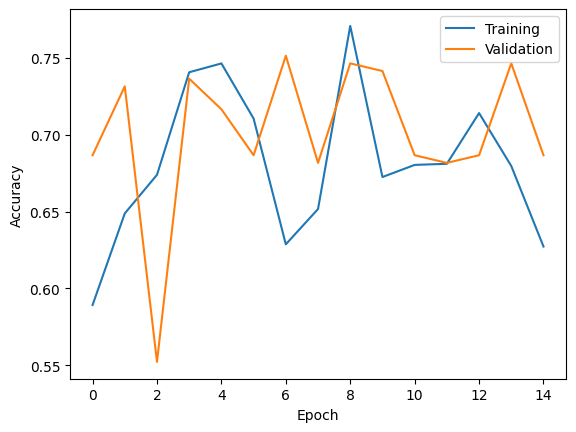

13/13 [==============================] - 10s 814ms/step - loss: 1.4899 - accuracy: 0.6867 - precision_10: 0.0000e+00 - recall_10: 0.0000e+00 - binary_accuracy: 0.6867 - auc_5: 0.7546 - true_positives_5: 0.0000e+00 - true_negatives_5: 274.0000 - false_positives_5: 0.0000e+00 - false_negatives_5: 125.0000
results [1.489876627922058, 0.6867167949676514, 0.0, 0.0, 0.6867167949676514, 0.7546277046203613, 0.0, 274.0, 0.0, 125.0]


In [ ]:
plt.plot(history_2_40.history['accuracy'])
plt.plot(history_2_40.history['val_accuracy'])

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.show()


results = model_2_40.evaluate(testDataset)
print('results', results)


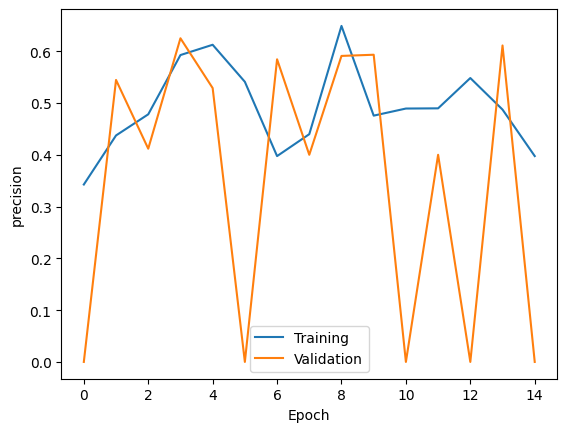

In [ ]:
plt.plot(history_2_40.history['precision_10'])
plt.plot(history_2_40.history['val_precision_10'])

plt.xlabel('Epoch')
plt.ylabel('precision')
plt.legend(['Training', 'Validation'])
plt.show()

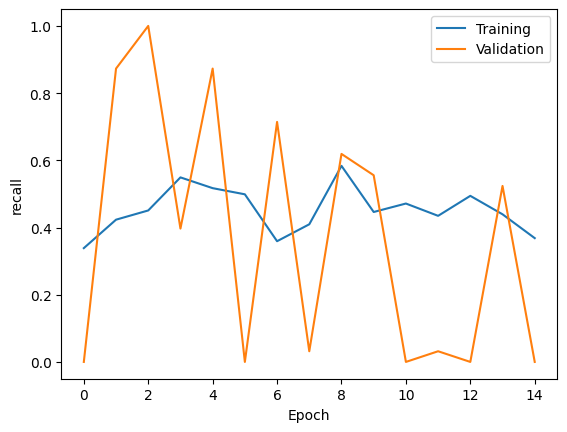

In [ ]:
plt.plot(history_2_40.history['recall_10'])
plt.plot(history_2_40.history['val_recall_10'])

plt.xlabel('Epoch')
plt.ylabel('recall')
plt.legend(['Training', 'Validation'])
plt.show()

In [ ]:
base_model_40 = MobileNetV2(include_top=False, weights='imagenet',input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

model_3_40 = keras.Sequential([
    base_model_40,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(units=1,activation ='sigmoid')
])
# Freeze the weights of the Mobilenet V2 layers
for layer in base_model_40.layers:
  layer.trainable =False

model_3_40.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_4   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_8 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
epochs = 15
model_3_40.compile(optimizer = 'adam',
                loss='binary_crossentropy',
                metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),
                       tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.AUC(),
                       tf.keras.metrics.TruePositives(), tf.keras.metrics.TrueNegatives(),
                       tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives()])

history_3_40 = model_3_40.fit(trainDataset, epochs =epochs, validation_data=(valDataset))



Epoch 1/15
44/44 [==============================] - 144s 3s/step - loss: 0.5240 - accuracy: 0.7376 - precision_11: 0.6437 - recall_11: 0.3638 - binary_accuracy: 0.7376 - auc_6: 0.7612 - true_positives_6: 159.0000 - true_negatives_6: 870.0000 - false_positives_6: 88.0000 - false_negatives_6: 278.0000 - val_loss: 0.5895 - val_accuracy: 0.6816 - val_precision_11: 0.4828 - val_recall_11: 0.2222 - val_binary_accuracy: 0.6816 - val_auc_6: 0.6877 - val_true_positives_6: 14.0000 - val_true_negatives_6: 123.0000 - val_false_positives_6: 15.0000 - val_false_negatives_6: 49.0000
Epoch 2/15
44/44 [==============================] - 118s 3s/step - loss: 0.3891 - accuracy: 0.8272 - precision_11: 0.7970 - recall_11: 0.6018 - binary_accuracy: 0.8272 - auc_6: 0.9013 - true_positives_6: 263.0000 - true_negatives_6: 891.0000 - false_positives_6: 67.0000 - false_negatives_6: 174.0000 - val_loss: 0.6053 - val_accuracy: 0.6766 - val_precision_11: 0.4792 - val_recall_11: 0.3651 - val_binary_accuracy: 0.6766 -

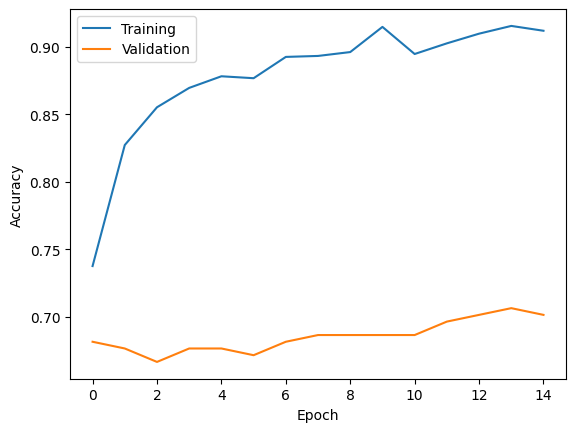

13/13 [==============================] - 35s 3s/step - loss: 1.2498 - accuracy: 0.6516 - precision_11: 0.3333 - recall_11: 0.1120 - binary_accuracy: 0.6516 - auc_6: 0.5339 - true_positives_6: 14.0000 - true_negatives_6: 246.0000 - false_positives_6: 28.0000 - false_negatives_6: 111.0000
results [1.2498334646224976, 0.6516290903091431, 0.3333333432674408, 0.1120000034570694, 0.6516290903091431, 0.5338832139968872, 14.0, 246.0, 28.0, 111.0]


In [ ]:
plt.plot(history_3_40.history['accuracy'])
plt.plot(history_3_40.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.show()

results = model_3_40.evaluate(testDataset)
print('results', results)

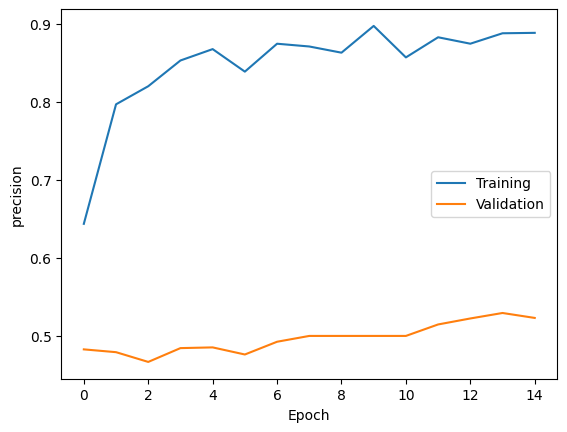

In [ ]:
plt.plot(history_3_40.history['precision_11'])
plt.plot(history_3_40.history['val_precision_11'])

plt.xlabel('Epoch')
plt.ylabel('precision')
plt.legend(['Training', 'Validation'])
plt.show()

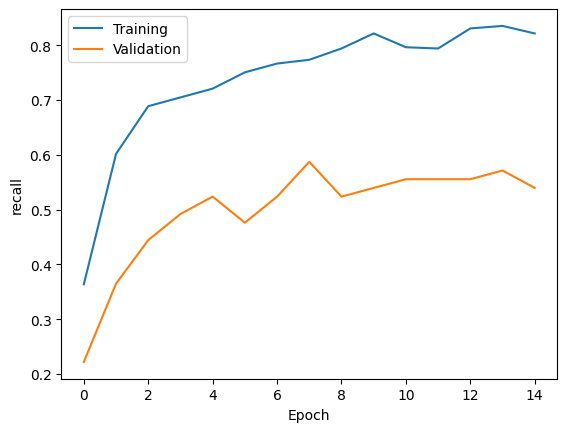

In [ ]:
plt.plot(history_3_40.history['recall_11'])
plt.plot(history_3_40.history['val_recall_11'])

plt.xlabel('Epoch')
plt.ylabel('recall')
plt.legend(['Training', 'Validation'])
plt.show()

Implementing image augmentation to 400x data in order to compare.

In [ ]:
benign_images =[]
for img in glob.glob('/content/drive/MyDrive/BreaKHis_v1/histology_slides/breast/benign/SOB/*/*/400X/*.png'):
    benign_images.append(img)
malign_images =[]
for img in glob.glob('/content/drive/MyDrive/BreaKHis_v1/histology_slides/breast/malignant/SOB/*/*/400X/*.png'):
    malign_images.append(img)

# Printing the count of collected benign and malignant images
print('There are {} benign images '.format(len(benign_images)))
print('There are {} malign images '.format(len(malign_images)))

There are 588 benign images 
There are 1232 malign images 


There are 1273 training images 
There are 182 validation images 
There are 365 test images 
Found 1273 validated image filenames belonging to 2 classes.
Found 182 validated image filenames belonging to 2 classes.
Found 365 validated image filenames belonging to 2 classes.
There are 40 training images 
There are 40 training images 
There are 6 validation images 
There are 12 test images 
Batch shape:  (32, 224, 224, 3)
Label shape:  (32,)
Label:  0.0


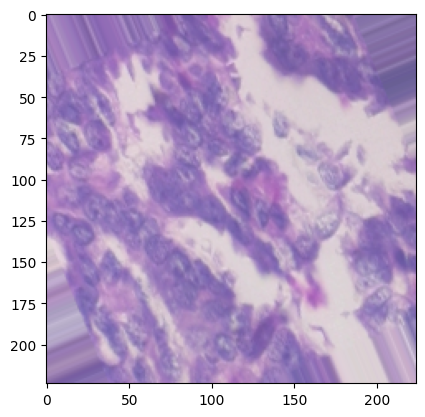

In [ ]:
# Paths of benign and malignant images, importing 400x

# Splitting the images into training, validation, and test sets
train_ben,val_ben,test_ben = np.split(benign_images,[int(len(benign_images)*0.7),int(len(benign_images)*0.8)])
train_mal,val_mal,test_mal = np.split(malign_images,[int(len(malign_images)*0.7),int(len(malign_images)*0.8)])

# Shuffling the lists of images
np.random.shuffle(benign_images)
np.random.shuffle(malign_images)

# Creating DataFrames for training, validation, and test sets
train_ben_df = pd.DataFrame({'image':train_ben,'label':'1'})
val_ben_df = pd.DataFrame({'image':val_ben,'label':'1'})
test_ben_df = pd.DataFrame({'image':test_ben,'label':'1'})

train_mal_df = pd.DataFrame({'image':train_mal,'label':'0'})
val_mal_df = pd.DataFrame({'image':val_mal,'label':'0'})
test_mal_df = pd.DataFrame({'image':test_mal,'label':'0'})

train_df = pd.concat([train_ben_df,train_mal_df])
val_df = pd.concat([val_ben_df,val_mal_df])
test_df = pd.concat([test_ben_df,test_mal_df])

# Printing the count of images in each dataset
print('There are {} training images '.format(len(train_df)))
print('There are {} validation images '.format(len(val_df)))
print('There are {} test images '.format(len(test_df)))

# Constants for image batch processing
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

# Creating ImageDataGenerator objects with augmentation
trainGenerator = ImageDataGenerator(
    rescale=1./255.,
    horizontal_flip=True,  # Augmentation: Horizontal Flip
    vertical_flip=True,    # Augmentation: Vertical Flip
    rotation_range=30       # Augmentation: Random Rotation (rotate images randomly up to 30 degrees)
)

valGenerator = ImageDataGenerator(rescale=1./255.)
testGenerator = ImageDataGenerator(rescale=1./255.)

# Converting data into datasets
trainDataset = trainGenerator.flow_from_dataframe(
    dataframe=train_df,
    class_mode="binary",
    x_col="image",
    y_col="label",
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    target_size=(IMG_HEIGHT,IMG_WIDTH) #set the height and width of the images
)

valDataset = valGenerator.flow_from_dataframe(
    dataframe=val_df,
    class_mode='binary',
    x_col="image",
    y_col="label",
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    target_size=(IMG_HEIGHT,IMG_WIDTH)
)

testDataset = testGenerator.flow_from_dataframe(
    dataframe=test_df,
    class_mode='binary',
    x_col="image",
    y_col="label",
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    target_size=(IMG_HEIGHT,IMG_WIDTH)
)

# Printing the count of images in each dataset  after augmentation
print('There are {} training images '.format(len(trainDataset)))
print('There are {} training images '.format(len(trainDataset)))
print('There are {} validation images '.format(len(valDataset)))
print('There are {} test images '.format(len(testDataset)))

########### data augmentation test

images, labels = next(iter(trainDataset))

print('Batch shape: ', images.shape)
print('Label shape: ', labels.shape)

plt.imshow(images[3])
print('Label: ', labels[3])



In [ ]:
# Define the model architecture
model_aug = keras.Sequential([
    keras.layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(256, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(512, (3, 3), activation='relu'),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(1, activation='sigmoid')
])

model_aug.summary()

# Define the number of epochs
epochs=15

# Compile the model
model_aug.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),
                       tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.AUC(),
                       tf.keras.metrics.TruePositives(), tf.keras.metrics.TrueNegatives(),
                       tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives()])


# Train the model
history_aug = model_aug.fit(trainDataset, epochs=epochs, validation_data=(valDataset))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 256)      0

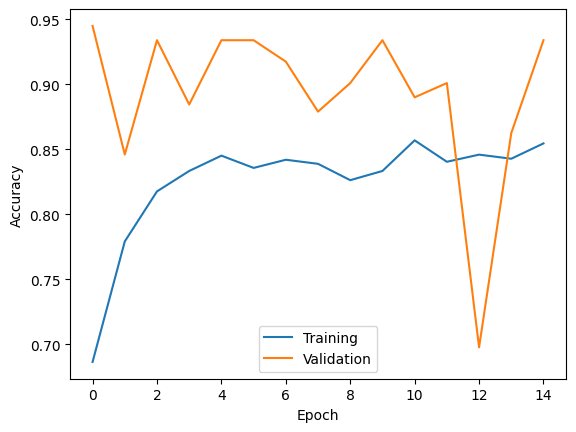

12/12 [==============================] - 101s 8s/step - loss: 0.5154 - accuracy: 0.8000 - precision: 0.7064 - recall: 0.6525 - binary_accuracy: 0.8000 - auc: 0.8623 - true_positives: 77.0000 - true_negatives: 215.0000 - false_positives: 32.0000 - false_negatives: 41.0000
results: [0.5154404640197754, 0.800000011920929, 0.7064220309257507, 0.6525423526763916, 0.800000011920929, 0.8623138666152954, 77.0, 215.0, 32.0, 41.0]


In [ ]:
# Plotting training and validation accuracy
plt.plot(history_aug.history['accuracy'])
plt.plot(history_aug.history['val_accuracy'])


plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.show()

# Evaluating the model on the test dataset
results = model_aug.evaluate(testDataset)
print('results:', results)

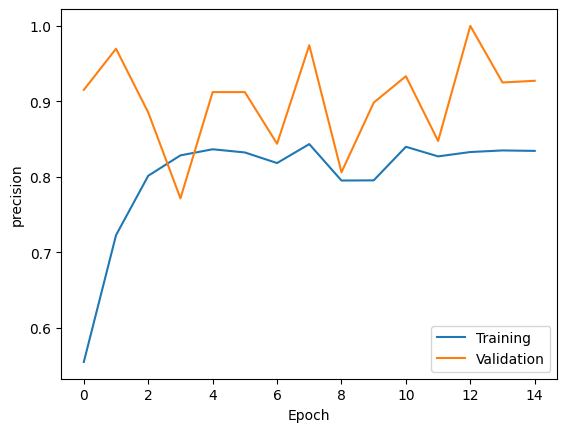

In [ ]:
# Plotting the precision scores for the training set
plt.plot(history_aug.history['precision'])

# Plotting the precision scores for the validation set
plt.plot(history_aug.history['val_precision'])

# Labeling the axes
plt.xlabel('Epoch')
plt.ylabel('precision')

# Adding a legend to differentiate between training and validation precision scores
plt.legend(['Training', 'Validation'])

# Displaying the plot
plt.show()

In [ ]:
# Make predictions on the test dataset
predictions = model_aug.predict(testDataset)
predicted_classes = np.where(predictions > 0.5, 1, 0)

# Calculate precision manually
from sklearn.metrics import precision_score

true_labels = test_df['label'].astype(int)
precision = precision_score(true_labels, predicted_classes)

print(f"Precision Score: {precision}")

# Create a confusion matrix using sklearn
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(true_labels, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

12/12 [==============================] - 57s 4s/step
Precision Score: 0.3394495412844037
Confusion Matrix:
[[175  72]
 [ 81  37]]


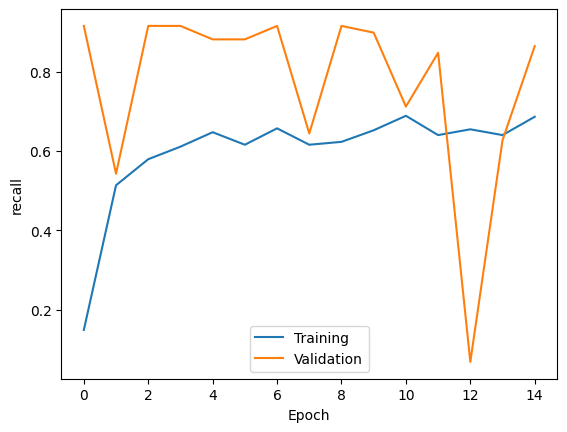

In [ ]:
# Plotting the recall scores
plt.plot(history_aug.history['recall'])
plt.plot(history_aug.history['val_recall'])

# Labeling the axes
plt.xlabel('Epoch')
plt.ylabel('recall')

# Adding a legend to differentiate between training and validation recall scores
plt.legend(['Training', 'Validation'])

# Displaying the plot
plt.show()

In [ ]:
# Creating a Sequential model architecture with dense layers

# Define the model architecture
model_2_aug = keras.Sequential([
    # Flatten layer to convert input data into a 1D array
    keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    # Dense hidden layer with 128 units and ReLU activation function
    keras.layers.Dense(units=128, activation= 'relu'),
    # Output layer with 1 unit and sigmoid activation for binary classification
    keras.layers.Dense(units=1, activation='sigmoid')
])
# Display a summary of the model architecture
model_2_aug.summary()

epochs = 15
model_2_aug.compile(optimizer = 'adam',
                loss='binary_crossentropy',
                metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),
                       tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.AUC(),
                       tf.keras.metrics.TruePositives(), tf.keras.metrics.TrueNegatives(),
                       tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives()])

history_2_aug = model_2_aug.fit(trainDataset, epochs =epochs, validation_data=(valDataset))



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 150528)            0         
                                                                 
 dense_3 (Dense)             (None, 128)               19267712  
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 19,267,841
Trainable params: 19,267,841
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
40/40 [==============================] - 68s 2s/step - loss: 24.6447 - accuracy: 0.5947 - precision_2: 0.3765 - recall_2: 0.3893 - binary_accuracy: 0.5947 - auc_2: 0.5466 - true_positives_2: 160.0000 - true_negatives_2: 597.0000 - false_positives_2: 265.0000 - false_negatives_2: 251.0000 - val_

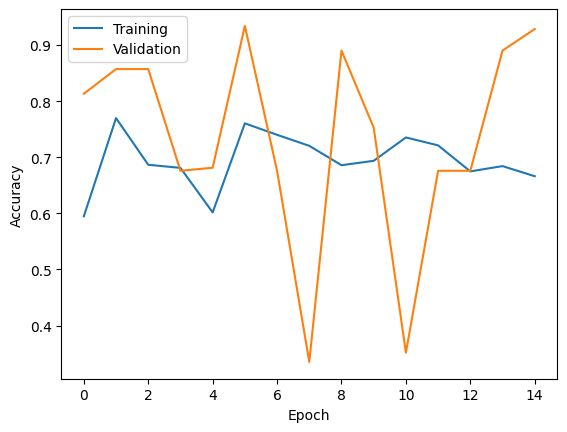

12/12 [==============================] - 7s 558ms/step - loss: 0.5165 - accuracy: 0.7425 - precision_2: 0.6277 - recall_2: 0.5000 - binary_accuracy: 0.7425 - auc_2: 0.8119 - true_positives_2: 59.0000 - true_negatives_2: 212.0000 - false_positives_2: 35.0000 - false_negatives_2: 59.0000
results: [0.5165315270423889, 0.7424657344818115, 0.6276595592498779, 0.5, 0.7424657344818115, 0.8119467496871948, 59.0, 212.0, 35.0, 59.0]


In [ ]:
# Plotting training and validation accuracy
plt.plot(history_2_aug.history['accuracy'])
plt.plot(history_2_aug.history['val_accuracy'])


plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.show()

# Evaluating the model on the test dataset
results = model_2_aug.evaluate(testDataset)
print('results:', results)

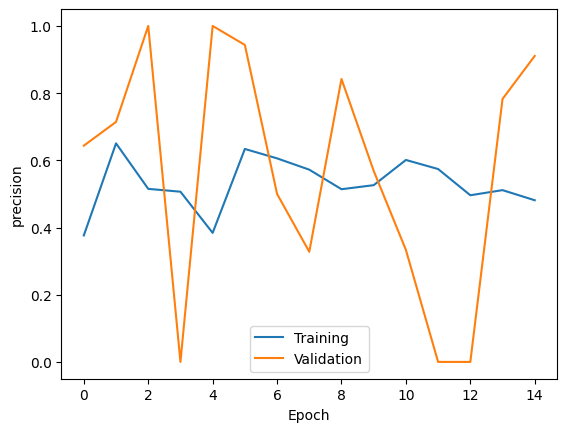

In [ ]:
# Plotting the precision scores for the training set
plt.plot(history_2_aug.history['precision_2'])

# Plotting the precision scores for the validation set
plt.plot(history_2_aug.history['val_precision_2'])

# Labeling the axes
plt.xlabel('Epoch')
plt.ylabel('precision')

# Adding a legend to differentiate between training and validation precision scores
plt.legend(['Training', 'Validation'])

# Displaying the plot
plt.show()

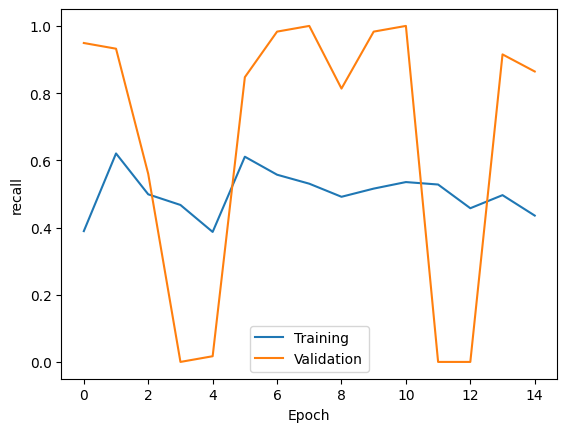

In [ ]:
# Plotting the recall scores
plt.plot(history_2_aug.history['recall_2'])
plt.plot(history_2_aug.history['val_recall_2'])

# Labeling the axes
plt.xlabel('Epoch')
plt.ylabel('recall')

# Adding a legend to differentiate between training and validation recall scores
plt.legend(['Training', 'Validation'])

# Displaying the plot
plt.show()

In [ ]:
# Model 3
base_model_aug = MobileNetV2(include_top=False, weights='imagenet',input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

model_3_aug = keras.Sequential([
    base_model_aug,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(units=1,activation ='sigmoid')
])
# Freeze the weights of the Mobilenet V2 layers
for layer in base_model_aug.layers:
  layer.trainable =False

model_3_aug.summary()

epochs = 15
model_3_aug.compile(optimizer = 'adam',
                loss='binary_crossentropy',
                metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),
                       tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.AUC(),
                       tf.keras.metrics.TruePositives(), tf.keras.metrics.TrueNegatives(),
                       tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives()])

history_3_aug = model_3_aug.fit(trainDataset, epochs =epochs, validation_data=(valDataset))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________
Epoch 1/15
40/40 [==============================] - 129s 3s/step - loss: 0.5253 - accuracy: 0.7203 - precision_4: 0.6062 - recall_4: 0.3820 - binary_accuracy: 0.7203 - auc_

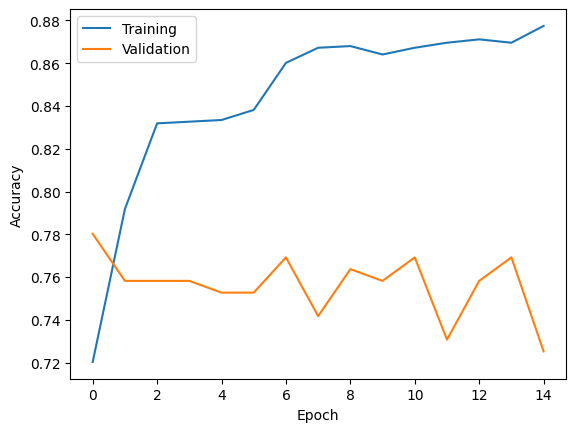

12/12 [==============================] - 24s 2s/step - loss: 0.7969 - accuracy: 0.6137 - precision_4: 0.3964 - recall_4: 0.3729 - binary_accuracy: 0.6137 - auc_4: 0.5726 - true_positives_4: 44.0000 - true_negatives_4: 180.0000 - false_positives_4: 67.0000 - false_negatives_4: 74.0000
results: [0.7968937158584595, 0.6136986017227173, 0.3963963985443115, 0.37288135290145874, 0.6136986017227173, 0.5725828409194946, 44.0, 180.0, 67.0, 74.0]


In [ ]:
# Plotting training and validation accuracy
plt.plot(history_3_aug.history['accuracy'])
plt.plot(history_3_aug.history['val_accuracy'])


plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.show()

# Evaluating the model on the test dataset
results = model_3_aug.evaluate(testDataset)
print('results:', results)

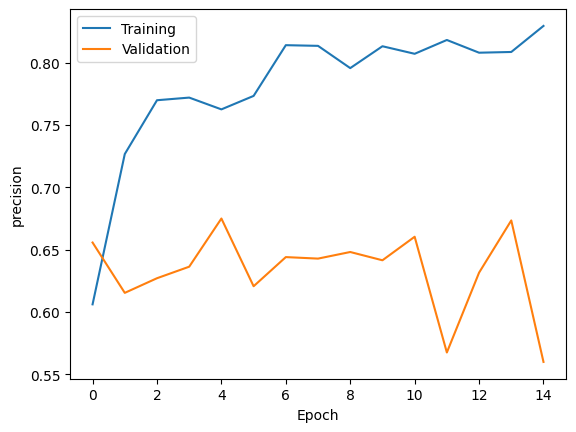

In [ ]:
# Plotting the precision scores for the training set
plt.plot(history_3_aug.history['precision_4'])

# Plotting the precision scores for the validation set
plt.plot(history_3_aug.history['val_precision_4'])

# Labeling the axes
plt.xlabel('Epoch')
plt.ylabel('precision')

# Adding a legend to differentiate between training and validation precision scores
plt.legend(['Training', 'Validation'])

# Displaying the plot
plt.show()

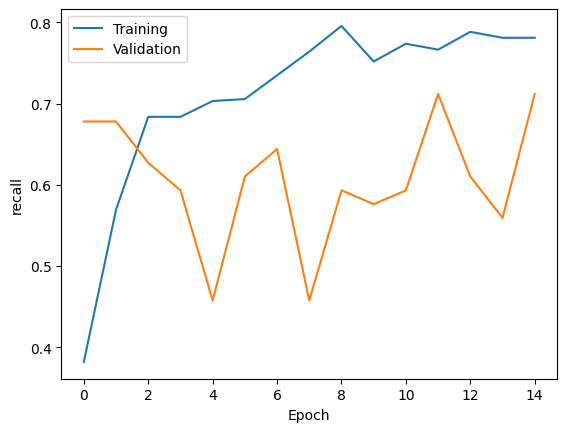

In [ ]:
# Plotting the recall scores
plt.plot(history_3_aug.history['recall_4'])
plt.plot(history_3_aug.history['val_recall_4'])

# Labeling the axes
plt.xlabel('Epoch')
plt.ylabel('recall')

# Adding a legend to differentiate between training and validation recall scores
plt.legend(['Training', 'Validation'])

# Displaying the plot
plt.show()